<a href="https://colab.research.google.com/github/RoBorregos/home-pipelines/blob/vision-dataset/vision/object_detector/notebooks/dataset_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object detector dataset generator

With this notebook you'll be able to artificially generate and automatically label
a dataset for detecting objects. You can bring your own images or test it by fetching images from Kaggle hub.

If running on colab, install dependencies:

In [ ]:
!pip install numpy opencv-python pillow pycocotools pyyaml torch ultralytics matplotlib imutils argparse groundingdino-py segment-anything

If you want to mount your google drive for training with checkpoints in colab and saving your progress run the following cell:

In [1]:
!rm -rf /content/sample_data
!rm -rf /content/.config
from google.colab import drive
import os
drive.mount('/content', force_remount=True)
workdir = "/content/MyDrive/RoBorregos/vision/dataset_generator/"
os.makedirs(workdir, exist_ok=True)

Mounted at /content


If not mounting a drive run the next cell:

In [20]:
workdir = "/content/"

In [34]:
import os
os.chdir("/")
import sys
import random
import json
import numpy as np
import cv2
from PIL import Image, ImageDraw, ImageEnhance, ImageFilter, ImageFont, UnidentifiedImageError
from pycocotools import mask
import json
import yaml
import csv
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import ultralytics
import time
import imutils
import argparse
from segment_anything import sam_model_registry, SamPredictor
import groundingdino.datasets.transforms as T
from groundingdino.models import build_model
from groundingdino.util import box_ops
from groundingdino.util.inference import load_model, predict
from groundingdino.util.slconfig import SLConfig
from groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from groundingdino.util.vl_utils import create_positive_map_from_span

# Attention!
If you have specific pictures, place the folders in ./images and skip the next two blocks of code which download a default dataset.

In [3]:
!pip install kagglehub
import kagglehub

dataset_path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")

In [4]:
!cp -r {dataset_path}/PetImages {workdir}
!mv {workdir}/PetImages {workdir}/images

def clean_and_trim_dataset(folder):
    total_removed = 0

    for category in ["Cat", "Dog"]:
        path = os.path.join(folder, category)
        valid_images = []

        # Step 1: Remove corrupt images
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            try:
                with Image.open(img_path) as img:
                    img.verify()
                valid_images.append(img_path)
            except (UnidentifiedImageError, OSError):
                os.remove(img_path)
                total_removed += 1

        print(f"Removed {total_removed} corrupt images from {category}")

        # Step 2: Remove part of the remaining valid images
        to_delete = random.sample(valid_images, len(valid_images) * 99 // 100)
        for img_path in to_delete:
            os.remove(img_path)

        print(f"Removed {len(to_delete)} images from {category} to reduce dataset size")

clean_and_trim_dataset(workdir + "images")

def count_files_in_dir(directory):
    # List all files (images) in the directory and count them
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    return len(files)

# Example usage for "Cat" and "Dog" folders
cat_folder = workdir + "images/Cat"
dog_folder = workdir + "images/Dog"

print(f"Number of cat images: {count_files_in_dir(cat_folder)}")
print(f"Number of dog images: {count_files_in_dir(dog_folder)}")

Removed 0 corrupt images from Cat
Removed 12374 images from Cat to reduce dataset size


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Removed 0 corrupt images from Dog
Removed 12374 images from Dog to reduce dataset size
Number of cat images: 125
Number of dog images: 125


## Rotate images

If needed rotate the image an amount of degrees.

In [57]:
angle = -90

def rotate_images_in_directory(directory):
    count = 0
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if os.path.isfile(filepath):
            try:
                with Image.open(filepath) as img:
                    rotated = img.rotate(angle, expand=True)  # Rotate right (clockwise)
                    rotated.save(filepath)
                    count += 1
            except Exception as e:
                print(f"Failed to process {filename}: {e}")
    print(f"Rotated {count} images in {directory}")

# Example usage:
rotate_images_in_directory(workdir + "bg")
# rotate_images_in_directory(workdir + "images/Can")
# rotate_images_in_directory(workdir + "images/Soap")


Rotated 150 images in /content/bg


## Resize images

In [6]:
base_path = workdir + "images"
size = 720

for class_dir in os.listdir(base_path):
    class_path = os.path.join(base_path, class_dir)

    if not os.path.isdir(class_path):
        continue

    for filename in os.listdir(class_path):
        file_path = os.path.join(class_path, filename)

        try:
            with Image.open(file_path) as img:
                img = img.resize((size, size))
                img.save(file_path)
        except (UnidentifiedImageError, OSError) as e:
            print(f"Removing corrupt file: {file_path}")
            os.remove(file_path)  # delete corrupt image

os.chdir(workdir)

## Download models

If you have already ran this and are using a volume/drive there is no need to run again.

In [6]:
!git clone https://github.com/IDEA-Research/GroundingDINO.git
!wget https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

Cloning into 'GroundingDINO'...
remote: Enumerating objects: 463, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 463 (delta 175), reused 135 (delta 135), pack-reused 223 (from 1)
Receiving objects: 100% (463/463), 12.87 MiB | 3.26 MiB/s, done.
Resolving deltas: 100% (241/241), done.
--2025-04-23 01:53:44--  https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://objects.githubusercontent.com/github-production-release-asset-2e65be/611591640/f221e500-c2fc-4fd3-b84e-8ad92a6923f3?X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Credential=releaseassetproduction%2F20250423%2Fus-east-1%2Fs3%2Faws4_request&X-Amz-Date=20250423T015345Z&X-Amz-Expires=300&X-Amz-Signature=54b0ad6a35993145c603f0973ae416b

## Segment images

In [7]:
SAVE_BB = False
DEBUG = False

results_path = workdir + "processed" #path to save results already processed and segmented images
config_file = workdir + "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"  # change the path of the model config file
checkpoint_path = workdir + "groundingdino_swint_ogc.pth"  # change the path of the model
output_dir = results_path
box_threshold = 0.3
text_threshold = 0.25
token_spans = None

sys.path.append("..")
sam_model = "h"

#use sam model
#wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
#wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth
if sam_model =="h":
  sam_checkpoint = workdir + "sam_vit_h_4b8939.pth"
  model_type = "vit_h"
else:
  sam_checkpoint = workdir + "sam_vit_l_0b3195.pth"
  model_type = "vit_l"

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using", device)
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

images=[]
annotations=[]
categories=[]

img_id=0
anno_id=0

# Make a list of all the directories in the path
base_path = workdir + "images"
path_to_classes = [f.path for f in os.scandir(base_path) if f.is_dir()]

def load_image(image_path):

    image_pil = Image.open(image_path).convert("RGB")  # load image

    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    image, _ = transform(image_pil, None)  # 3, h, w
    return image_pil, image


def load_model(model_config_path, model_checkpoint_path, cpu_only=False):
    args = SLConfig.fromfile(model_config_path)
    args.device = device
    model = build_model(args)
    checkpoint = torch.load(model_checkpoint_path, map_location="cpu")
    load_res = model.load_state_dict(clean_state_dict(checkpoint["model"]), strict=False)
    if DEBUG:
        print(load_res)
    _ = model.eval()
    return model


def get_grounding_output(model, image, caption, box_threshold, text_threshold=None, with_logits=True, cpu_only=False, token_spans=None):
    assert text_threshold is not None or token_spans is not None, "text_threshould and token_spans should not be None at the same time!"
    caption = caption.lower()
    caption = caption.strip()
    if not caption.endswith("."):
        caption = caption + "."
    model = model.to(device)
    image = image.to(device)
    with torch.no_grad():
        if DEBUG:
            print("Running model...")
        outputs = model(image[None], captions=[caption])
    logits = outputs["pred_logits"].sigmoid()[0]  # (nq, 256)
    boxes = outputs["pred_boxes"][0]  # (nq, 4)

    # filter output
    if token_spans is None:
        logits_filt = logits.cpu().clone()
        boxes_filt = boxes.cpu().clone()
        filt_mask = logits_filt.max(dim=1)[0] > box_threshold
        logits_filt = logits_filt[filt_mask]  # num_filt, 256
        boxes_filt = boxes_filt[filt_mask]  # num_filt, 4

        # get phrase
        tokenlizer = model.tokenizer
        tokenized = tokenlizer(caption)
        # build pred
        pred_phrases = []
        for logit, box in zip(logits_filt, boxes_filt):
            pred_phrase = get_phrases_from_posmap(logit > text_threshold, tokenized, tokenlizer)
            if with_logits:
                pred_phrases.append(pred_phrase + f"({str(logit.max().item())[:4]})")
            else:
                pred_phrases.append(pred_phrase)
    else:
        # given-phrase mode
        positive_maps = create_positive_map_from_span(
            model.tokenizer(text_prompt),
            token_span=token_spans
        ).to(image.device) # n_phrase, 256

        logits_for_phrases = positive_maps @ logits.T # n_phrase, nq
        all_logits = []
        all_phrases = []
        all_boxes = []
        for (token_span, logit_phr) in zip(token_spans, logits_for_phrases):
            # get phrase
            phrase = ' '.join([caption[_s:_e] for (_s, _e) in token_span])
            # get mask
            filt_mask = logit_phr > box_threshold
            # filt box
            all_boxes.append(boxes[filt_mask])
            # filt logits
            all_logits.append(logit_phr[filt_mask])
            if with_logits:
                logit_phr_num = logit_phr[filt_mask]
                all_phrases.extend([phrase + f"({str(logit.item())[:4]})" for logit in logit_phr_num])
            else:
                all_phrases.extend([phrase for _ in range(len(filt_mask))])
        boxes_filt = torch.cat(all_boxes, dim=0).cpu()
        pred_phrases = all_phrases
    return boxes_filt, pred_phrases


def verify_or_create_dir(path):
    os.makedirs(path, exist_ok=True)
    if DEBUG:
        print(f"Verified/created: {path}")


def count_all_files_in_dir(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        count += len([f for f in files if os.path.isfile(os.path.join(root, f))])
    return count


# Get total number of images to process
image_dir = workdir + "images"
number_of_images = count_all_files_in_dir(image_dir)
print(f"Total image files: {number_of_images}")

# Check if results directory exists, else create it
verify_or_create_dir(results_path)

# Main loop
i = 0
for class_path in path_to_classes:
    imgPaths = os.listdir(class_path)
    if SAVE_BB:
        class_name = os.path.basename(class_path)
        verify_or_create_dir(f"{results_path}/bbs/{class_name}")

    for imgPath in imgPaths:
        if DEBUG:
            print(f"Processing image: {imgPath}")
        print(f"%{i * 100 / number_of_images}")
        img = imutils.resize(cv2.imread(f"{class_path}/{imgPath}"))
        if img is None:
            continue

    #------------------------start grounding----------------------------------------------

        # Image_path = args.image_path
        cpu_only = False if torch.cuda.is_available() else True

        # Load image
        image_pil, image = load_image(f"{class_path}/{imgPath}")

        # Load model
        model = load_model(config_file, checkpoint_path, cpu_only=cpu_only)

        # Set the text_threshold to None if token_spans is set.
        if token_spans is not None:
            text_threshold = None
            print("Using token_spans. Set the text_threshold to None.")

        # Run model
        text_prompt = os.path.basename(class_path)
        boxes_filt, pred_phrases = get_grounding_output(
            model, image, text_prompt, box_threshold, text_threshold, cpu_only=cpu_only, token_spans=eval(f"{token_spans}")
        )

        # Found bb dimensions

        size = image_pil.size
        pred_dict = {
            "boxes": boxes_filt,
            "size": [size[1], size[0]],  # H, W
            "labels": pred_phrases,
        }

        H, W = pred_dict["size"]
        boxes = pred_dict["boxes"]
        labels = pred_dict["labels"]
        assert len(boxes) == len(labels), "boxes and labels must have same length"

        draw = ImageDraw.Draw(image_pil)
        mask = Image.new("L", image_pil.size, 0)
        mask_draw = ImageDraw.Draw(mask)

        #change pil image to cv2 image
        img = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)
        img2 = img.copy()
        # draw boxes and masks
        for box, label in zip(boxes, labels):
            # from 0..1 to 0..W, 0..H
            box = box * torch.Tensor([W, H, W, H])
            # from xywh to xyxy
            box[:2] -= box[2:] / 2
            box[2:] += box[:2]
            # random color
            color = tuple(np.random.randint(0, 255, size=1).tolist())
            # draw
            padding = 10
            x0, y0, x1, y1 = box
            x0, y0, x1, y1 = int(x0)-padding, int(y0)-padding, int(x1)+padding, int(y1)+padding

            #validate if the bounding box is inside the image
            if x0 < 0:
                x0 = 0
            if y0 < 0:
                y0 = 0
            if x1 > W:
                x1 = W
            if y1 > H:
                y1 = H

            #draw rectangles
            cv2.rectangle(img2, (x0, y0), (x1, y1), color, 2)

            draw.rectangle([x0, y0, x1, y1], outline=color, width=6)
            # draw.text((x0, y0), str(label), fill=color)

            font = ImageFont.load_default()
            if hasattr(font, "getbbox"):
                bbox = draw.textbbox((x0, y0), str(label), font)
            else:
                w, h = draw.textsize(str(label), font)
                bbox = (x0, y0, w + x0, y0 + h)
            # bbox = draw.textbbox((x0, y0), str(label))
            draw.rectangle(bbox, fill=color)
            draw.text((x0, y0), str(label), fill="white")

            mask_draw.rectangle([x0, y0, x1, y1], fill=255, width=6)

    # ----------------Start SAM--------------------------------------------------------------

            class_name = class_path.split("/")[-1]
            sam_bounding_box = np.array([x0, y0, x1, y1])
            ran_sam = False
            #run sam
            if ran_sam == False:
                predictor.set_image(img)
                ran_sam = True

            mask, _, _ = predictor.predict(
                point_coords=None,
                point_labels=None,
                box=sam_bounding_box,
                multimask_output=False,
            )

            mask, _, _ = predictor.predict(box=sam_bounding_box, multimask_output=False)

            # Make png mask
            contours, _ = cv2.findContours(mask[0].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # Your call to find the contours

            # threshold input image using otsu thresholding as mask and refine with morphology
            ret, pngmask = cv2.threshold(mask[0].astype(np.uint8), 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
            kernel = np.ones((9,9), np.uint8)
            pngmask = cv2.morphologyEx(pngmask, cv2.MORPH_CLOSE, kernel)
            pngmask = cv2.morphologyEx(pngmask, cv2.MORPH_OPEN, kernel)
            result = img.copy()
            result = cv2.cvtColor(result, cv2.COLOR_BGR2BGRA)
            result[:, :, 3] = pngmask

    # ----------------Save Images-----------------------------------------------------------------

            if SAVE_BB:
              cv2.imwrite(f"{results_path}/bbs/{class_name}/{imgPath}", img2)

            verify_or_create_dir(f"{results_path}/{class_name}")

            file_path = f"{results_path}/{class_name}/{imgPath[:-4]}.png"
            if os.path.exists(file_path):
                if os.path.exists(f"{results_path}/{class_name}/{imgPath[:-4]}_1.png"):
                    if DEBUG:
                        print("File already exists, saving with _2")
                    cv2.imwrite(f"{results_path}/{class_name}/{imgPath[:-4]}_2.png", result)
                else:
                    if DEBUG:
                        print("File already exists, saving with _1")
                    file_path = f"{results_path}/{class_name}/{imgPath[:-4]}_1.png"

            cv2.imwrite(file_path, result)
            ran_sam = False
        i = i + 1

Using cuda
Total image files: 150
%0.0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/pytorch/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/groundingdino/models/GroundingDINO/transformer.py:862: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `

%0.6666666666666666
final text_encoder_type: bert-base-uncased
%1.3333333333333333
final text_encoder_type: bert-base-uncased
%2.0
final text_encoder_type: bert-base-uncased
%2.6666666666666665
final text_encoder_type: bert-base-uncased
%3.3333333333333335
final text_encoder_type: bert-base-uncased
%4.0
final text_encoder_type: bert-base-uncased
%4.666666666666667
final text_encoder_type: bert-base-uncased
%5.333333333333333
final text_encoder_type: bert-base-uncased
%6.0
final text_encoder_type: bert-base-uncased
%6.666666666666667
final text_encoder_type: bert-base-uncased
%7.333333333333333
final text_encoder_type: bert-base-uncased
%8.666666666666666
final text_encoder_type: bert-base-uncased
%9.333333333333334
final text_encoder_type: bert-base-uncased
%10.0
final text_encoder_type: bert-base-uncased
%10.666666666666666
final text_encoder_type: bert-base-uncased
%11.333333333333334
final text_encoder_type: bert-base-uncased
%12.0
final text_encoder_type: bert-base-uncased
%12.6666

## Manually check segmented images

Press k to keep an images or d to delete it. You may also use the buttons.

In [8]:
import os
from IPython.display import display, Image, Javascript, clear_output
import ipywidgets as widgets

# Step 1: Collect image paths
image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp')
image_paths = [
    os.path.join(root, file)
    for root, _, files in os.walk('/content/processed')
    for file in files if file.lower().endswith(image_extensions)
]

# Step 2: Create widgets
output = widgets.Output()
hidden_input = widgets.Text(placeholder='Press k (keep) or d (delete)', layout=widgets.Layout(width='0px'))
keep_button = widgets.Button(description="Keep", button_style='success')
delete_button = widgets.Button(description="Delete", button_style='danger')

# Step 3: State management
index = {"i": 0}

def show_image():
    output.clear_output(wait=True)
    if index["i"] < len(image_paths):
        with output:
            display(Image(filename=image_paths[index["i"]], width=400))
            display(widgets.HBox([keep_button, delete_button]))
            hidden_input.value = ''  # Clear input for next key
            hidden_input.focus()
    else:
        with output:
            print("✅ All images reviewed!")

def keep_image(_=None):
    index["i"] += 1
    show_image()

def delete_image(_=None):
    try:
        os.remove(image_paths[index["i"]])
        print(f"🗑️ Deleted: {image_paths[index['i']]}")
    except Exception as e:
        print(f"⚠️ Error deleting file: {e}")
    index["i"] += 1
    show_image()

def handle_keypress(change):
    key = change["new"].lower()
    if key == 'k':
        keep_image()
    elif key == 'd':
        delete_image()

# Step 4: Bind events
keep_button.on_click(keep_image)
delete_button.on_click(delete_image)
hidden_input.observe(handle_keypress, names='value')

# Step 5: Inject JavaScript to forward keypresses to the hidden text widget
js_focus = Javascript("""
document.addEventListener("keydown", (e) => {
    const input = document.querySelector('input[placeholder="Press k (keep) or d (delete)"]');
    if (input) {
        input.value = e.key;
        input.dispatchEvent(new Event('input', { bubbles: true }));
    }
});
""")

# Step 6: Display everything
display(widgets.HTML("<b>Use 'k' to Keep, 'd' to Delete</b>"))
display(hidden_input)
display(js_focus)
display(output)
show_image()


HTML(value="<b>Use 'k' to Keep, 'd' to Delete</b>")

Text(value='', layout=Layout(width='0px'), placeholder='Press k (keep) or d (delete)')

<IPython.core.display.Javascript object>

Output()

## Setup for dataset generation

In [27]:
from PIL import Image

results_path = workdir + "DS_res/"
path_to_classes = [f.path for f in os.scandir(workdir + "processed") if f.is_dir()]

for class_path in path_to_classes:
    class_name = os.path.basename(class_path)
    verify_or_create_dir(results_path + class_name)
    for file_name in os.listdir(class_path):
        try:
            file_path = class_path + "/" + file_name
            my_image = Image.open(file_path)
            black = Image.new('RGBA', my_image.size)
            my_image = Image.composite(my_image, black, my_image)
            cropped_image = my_image.crop(my_image.getbbox())
            cropped_image.save(f"{results_path}{class_name}/{file_name}")
            print(f"{file_name} done")
        except Exception as e:
            print(f"{file_name} failed {e}")
            continue

20250422_191908_005.png done
IMG_20250425_135738.png done
IMG_20250425_135759.png done
IMG_20250426_093939.png done
IMG_20250426_093853.png done
IMG_20250426_093840.png done
IMG_20250426_093922.png done
20250422_191912_034.png done
20250422_191912_012.png done
IMG_20250426_093934.png done
IMG_20250426_093848.png done
20250422_191908_030.png done
IMG_20250426_093938.png done
IMG_20250426_093855.png done
IMG_20250425_135743.png done
IMG_20250425_135737.png done
IMG_20250425_135728.png done
IMG_20250426_093909.png done
IMG_20250425_135808.png done
IMG_20250426_093916.png done
IMG_20250425_135755.png done
IMG_20250426_093852.png done
IMG_20250426_093924.png done
IMG_20250425_135758.png done
IMG_20250426_093915.png done
IMG_20250426_093907.png done
IMG_20250425_135752.png done
IMG_20250425_135801.png done
IMG_20250425_135734.png done
IMG_20250426_093936.png done
20250422_191912_016.png done
IMG_20250426_093845.png done
IMG_20250425_135733.png done
IMG_20250426_093911.png done
IMG_20250425_1

In [28]:
# Get all subfolders inside results_path
path_to_classes = [f.path for f in os.scandir(results_path) if f.is_dir() and "bbs" not in f.name]

# Build list of (path, class_name) tuples
fg_folders = [(path, os.path.basename(path)) for path in path_to_classes]

# Define folders
bg_folder = workdir + "bg/"
verify_or_create_dir(bg_folder)
output_folder = workdir + "ds_final/"

In [29]:
objects_list = [os.path.basename(class_path) for class_path in path_to_classes]
annotations_ID = {}
categories = []
for i, object in enumerate(objects_list):
    annotations_ID[object] = i
    categories.append({"id": i, "name": object})

print(annotations_ID)
print(categories)

{'Soap': 0, 'Can': 1, 'Box': 2}
[{'id': 0, 'name': 'Soap'}, {'id': 1, 'name': 'Can'}, {'id': 2, 'name': 'Box'}]


In [30]:
# Load the list of files in each of the three folders
fg_files = {}
for folder, category in fg_folders:
    fg_files[category] = os.listdir(folder)

In [31]:
# Define the folder structure
subfolders = [
    "train/images",
    "train/labels",
    "test/images",
    "test/labels",
    "valid/images",
    "valid/labels",
]

# Create them
for sub in subfolders:
    verify_or_create_dir(os.path.join(output_folder, sub))

# Autolabel

For this step, add background images to ./bg

You can run the next cell to download and format a default dataset.

In [15]:
!pip install kagglehub
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("balraj98/stanford-background-dataset")
os.system(f'cp "{dataset_path}/images/"* {workdir}bg/')

dataset_path = kagglehub.dataset_download("adikurniawan/color-dataset-for-color-recognition")
os.system(f'find "{dataset_path}/training_dataset/" -type f -exec cp {{}} {workdir}bg/ \;')

Looking in indexes: http://jetson.webredirect.org/jp6/cu126, https://pypi.ngc.nvidia.com


0

## Remove corrupt images

You con also remove a percentage of images by modifying *delete_percentage*

In [32]:
delete_percentage = 0  # e.g., 0.1 for 10%
debug = False  # Set to True to print deleted files
min_width = 0  # Minimum width
min_height = 0  # Minimum height

def clean_and_trim_dataset(folder):
    total_removed = 0
    low_res_removed = 0
    valid_images = []

    # Step 1: Remove corrupt images and low resolution ones
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        if not os.path.isfile(img_path):
            continue
        try:
            with Image.open(img_path) as img:
                img.verify()

            with Image.open(img_path) as img:  # reopen to get size
                width, height = img.size
                if width < min_width or height < min_height:
                    if debug:
                        print(f"Deleting low resolution image: {img_path} ({width}x{height})")
                    os.remove(img_path)
                    low_res_removed += 1
                else:
                    valid_images.append(img_path)

        except (UnidentifiedImageError, OSError):
            if debug:
                print(f"Deleting corrupt image: {img_path}")
            os.remove(img_path)
            total_removed += 1

    print(f"Removed {total_removed} corrupt images")
    print(f"Removed {low_res_removed} low resolution images")

    # Step 2: Remove a percentage of the valid images
    to_delete_count = int(len(valid_images) * delete_percentage)
    to_delete = random.sample(valid_images, to_delete_count)
    for img_path in to_delete:
        if debug:
            print(f"Deleting random image for dataset reduction: {img_path}")
        os.remove(img_path)

    print(f"Removed {len(to_delete)} images to reduce dataset size")

def count_files_in_dir(directory):
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    return len(files)

# Apply on /content/bg
clean_and_trim_dataset(workdir + "bg")

# Count remaining images
print(f"Remaining number of images: {count_files_in_dir(workdir + 'bg')}")


Removed 0 corrupt images
Removed 0 low resolution images
Removed 0 images to reduce dataset size
Remaining number of images: 1115


## Resize bg images

In [19]:
base_path = workdir + "bg"
size = 640

for filename in os.listdir(base_path):
    file_path = os.path.join(base_path, filename)

    try:
        with Image.open(file_path) as img:
            img = img.resize((size, size))
            img.save(file_path)
    except (UnidentifiedImageError, OSError) as e:
        print(f"Removing corrupt file: {file_path}")
        os.remove(file_path)  # delete corrupt image

os.chdir(workdir)

/content/bg/IMG_20250426_094146.jpg
/content/bg/0004294.jpg
/content/bg/0102403.jpg
/content/bg/6000103.jpg
/content/bg/6000268.jpg
/content/bg/6000076.jpg
/content/bg/9001991.jpg
/content/bg/grey23.png
/content/bg/6000077.jpg
/content/bg/orange9.jpg
/content/bg/6000057.jpg
/content/bg/6000318.jpg
/content/bg/6000081.jpg
/content/bg/1000061.jpg
/content/bg/5000188.jpg
/content/bg/9001034.jpg
/content/bg/1000875.jpg
/content/bg/6000340.jpg
/content/bg/9001713.jpg
/content/bg/IMG_20250426_094034.jpg
/content/bg/black8.jpg
/content/bg/3000119.jpg
/content/bg/6000094.jpg
/content/bg/9000002.jpg
/content/bg/IMG_20250426_094141~2.jpg
/content/bg/9002090.jpg
/content/bg/6000262.jpg
/content/bg/IMG_20250426_094003.jpg
/content/bg/6000204.jpg
/content/bg/996633.png
/content/bg/9000989.jpg
/content/bg/IMG_20250426_094018.jpg
/content/bg/IMG_20250426_094234.jpg
/content/bg/black21.jpg
/content/bg/feff7f.png
/content/bg/0010950.jpg
/content/bg/6000028.jpg
/content/bg/9002827.jpg
/content/bg/IMG_20

## Image generator

This cell takes the segmented images of the classes and backgrounds and generate images with a random amount of objects in them scattered around.

In [37]:
images = []
annotations = []
annotations2 = []
annot_csv = []

img_id = int(0)
anno_id = int(0)

# Ratios at which these values will be modified
rescaling_min = 0.15
rescaling_max = 0.40

# Define the maximum overlap as a percentage
max_overlap_pct = 5

trainfolder = output_folder + "train/"
validfolder = output_folder + "valid/"

images_to_generate = 3000
max_objects_per_image = 5

for j in range(images_to_generate):
    with open(f'{trainfolder}labels/{img_id}.txt', 'w') as file:
        pass

    # Decide if this image should be empty
    if random.random() < 0.10:  # 10% chance
        num_objects = 0
    else:
        num_objects = random.randint(1, max_objects_per_image)
        
    fg_categories = random.choices(objects_list, k=num_objects)

    fg_files_selected = [[category, random.choice(fg_files[category])] for category in fg_categories]

    fg_imgs = []
    for img in fg_files_selected:
        folder = [f[0] for f in fg_folders if f[1] == img[0]][0]
        fg_img = Image.open(folder + "/" + img[1]).convert("RGBA")
        fg_imgs.append([img[0], Image.open(folder + "/" + img[1]), folder + img[1]])

    bg_files = os.listdir(bg_folder)
    bg_file = random.choice(bg_files)
    bg_img = Image.open(bg_folder + bg_file)
    bg_img = bg_img.convert("RGBA")    

    occupied_mask = np.zeros((bg_img.height, bg_img.width), dtype=np.uint8)

    for img in fg_imgs:
        fg_img = img[1]

        angle = random.randint(-5, 5)
        scale = random.uniform(rescaling_min, rescaling_max)
        fg_img = fg_img.rotate(angle, resample=Image.BICUBIC, expand=True)
        fg_img = fg_img.resize((int(bg_img.width * scale), int(bg_img.height * scale)))

        MAX_OBJ_WIDTH = bg_img.width * 0.25
        MAX_OBJ_HEIGHT = bg_img.height * 0.25

        if fg_img.width > MAX_OBJ_WIDTH or fg_img.height > MAX_OBJ_HEIGHT:
            aspect_ratio = fg_img.width / fg_img.height
            if aspect_ratio >= 1:
                fg_img = fg_img.resize((int(MAX_OBJ_WIDTH), int(MAX_OBJ_WIDTH / aspect_ratio)))
            else:
                fg_img = fg_img.resize((int(MAX_OBJ_HEIGHT * aspect_ratio), int(MAX_OBJ_HEIGHT)))

        fg_img = ImageEnhance.Brightness(fg_img).enhance(random.uniform(0.7, 1.3))
        fg_img = ImageEnhance.Contrast(fg_img).enhance(random.uniform(0.9, 1.1))
        fg_img = ImageEnhance.Color(fg_img).enhance(random.uniform(0.7, 1.3))
        fg_img = fg_img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.0, 0.5)))

        img[1] = fg_img

        max_x = bg_img.width - fg_img.width
        max_y = bg_img.height - fg_img.height

        for attempt in range(50):
            x = random.randint(0, max_x)
            y = random.randint(0, max_y)

            fg_mask = np.array(fg_img.split()[-1]) > 0
            occ_crop = occupied_mask[y:y + fg_img.height, x:x + fg_img.width]
            overlap = np.sum(np.logical_and(fg_mask, occ_crop))
            allowed_overlap = max_overlap_pct / 100 * np.sum(fg_mask)

            if overlap <= allowed_overlap:
                occupied_mask[y:y + fg_img.height, x:x + fg_img.width] = np.logical_or(occ_crop, fg_mask)
                break
        else:
            continue

        seg_img = fg_img
        img_arr = np.array(seg_img)
        mask = img_arr[:, :, 3] != 0

        segmentation = []
        for i in range(mask.shape[0]):
            for j in range(mask.shape[1]):
                if mask[i, j]:
                    segmentation.append(j + x)
                    segmentation.append(i + y)
        segmentation = [segmentation]

        area = abs(sum(
            segmentation[0][2 * i] * segmentation[0][(2 * i + 3) % len(segmentation[0])] -
            segmentation[0][(2 * i + 2) % len(segmentation[0])] * segmentation[0][2 * i + 1]
            for i in range(len(segmentation[0]) // 2)
        )) / 2

        bg_img.paste(fg_img, (x, y), fg_img)

        x1, y1 = x, y
        x2 = x + fg_img.width
        y2 = y + fg_img.height

        if x2 <= x1 or y2 <= y1:
            continue

        x_center_ann = ((x1 + x2) / 2) / bg_img.width
        y_center_ann = ((y1 + y2) / 2) / bg_img.height
        width_ann = (x2 - x1) / bg_img.width
        height_ann = (y2 - y1) / bg_img.height

        if not (0 <= x_center_ann <= 1 and 0 <= y_center_ann <= 1 and 0 <= width_ann <= 1 and 0 <= height_ann <= 1):
            continue

        with open(f'{trainfolder}labels/{img_id}.txt', 'a') as f:
            f.write(f"{annotations_ID[img[0]]} {x_center_ann} {y_center_ann} {width_ann} {height_ann}\n")

        annotations2.append({
            "id": anno_id, "image_id": img_id, "category_id": annotations_ID[img[0]],
            "bbox": [x, y, fg_img.width, fg_img.height],
            "segmentation": segmentation, "area": area, "iscrowd": 0
        })
        annotations.append({
            "id": anno_id, "image_id": img_id, "category_id": annotations_ID[img[0]],
            "bbox": [x, y, fg_img.width, fg_img.height],
            "segmentation": [], "area": fg_img.height * fg_img.width, "iscrowd": 0
        })
        annot_csv.append([
            "TRAIN", output_folder + str(img_id)+".jpg", img[0], x/bg_img.width, y/bg_img.height,
            "", "", (x+fg_img.width)/bg_img.width, (y+fg_img.height)/bg_img.height
        ])

        anno_id += 1

    bg_img = bg_img.convert("RGB")
    bg_img.save(f"{trainfolder}images/" + str(img_id) + ".jpg", quality=100)
    images.append({"id": img_id, "file_name": str(img_id) + ".jpg", "height": bg_img.height, "width": bg_img.width})
    img_id += 1

# Create data.yaml
data = dict(
    train=f"{trainfolder}images",
    val=f"{validfolder}images",
    test=f"{validfolder}images",
    nc=len(annotations_ID),
    names=list(annotations_ID.keys())
)

with open(f'{output_folder}data.yaml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)


## Check generated images

This cell shows n random images from the dataset and draws the bounding boxes from the labels.

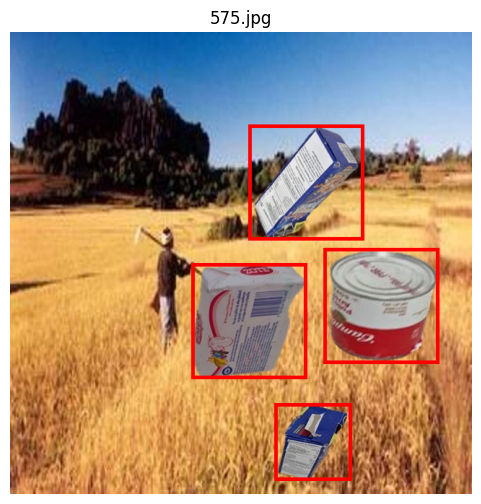

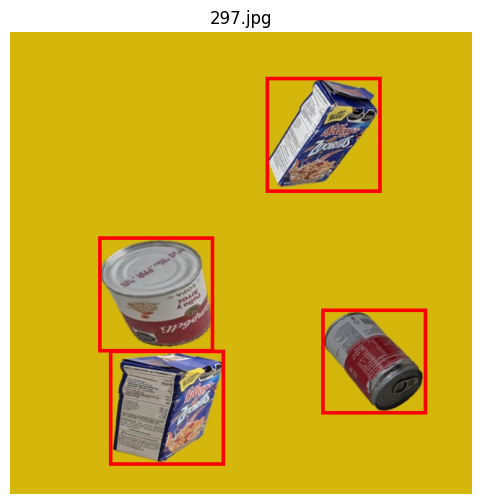

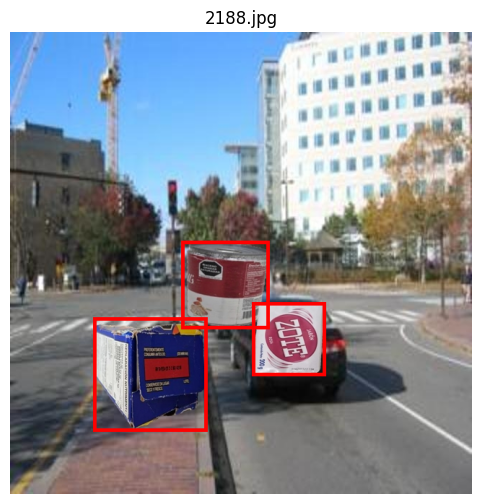

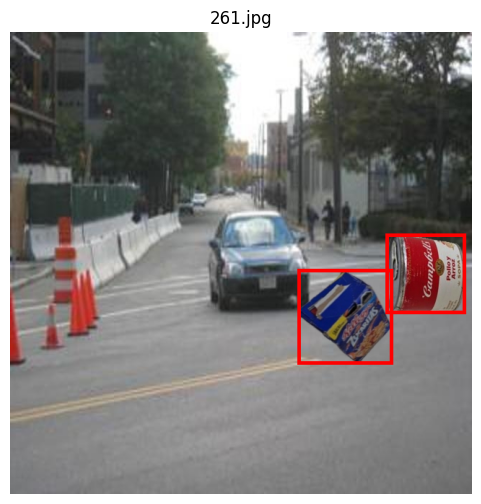

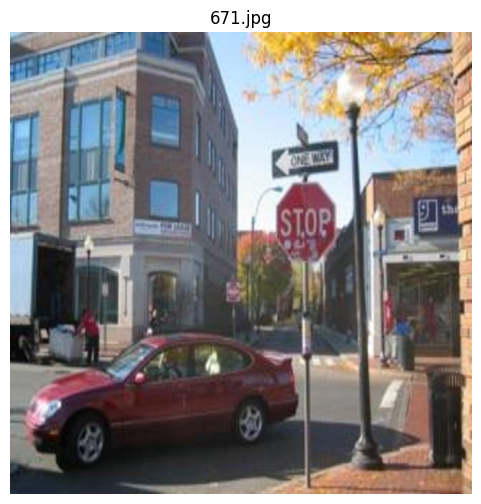

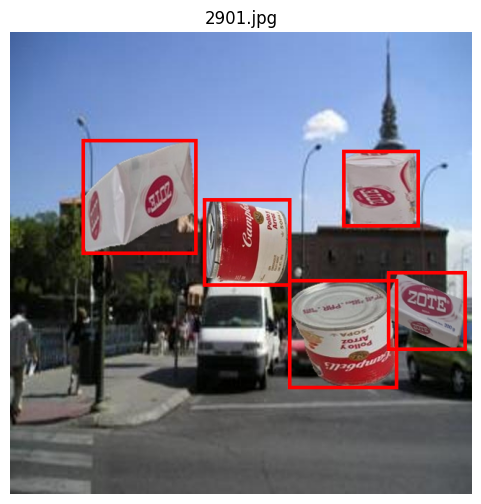

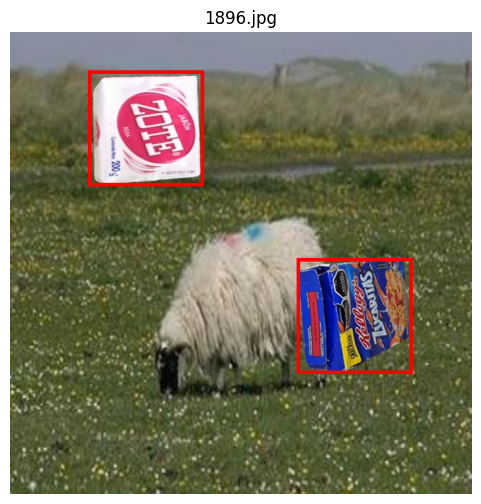

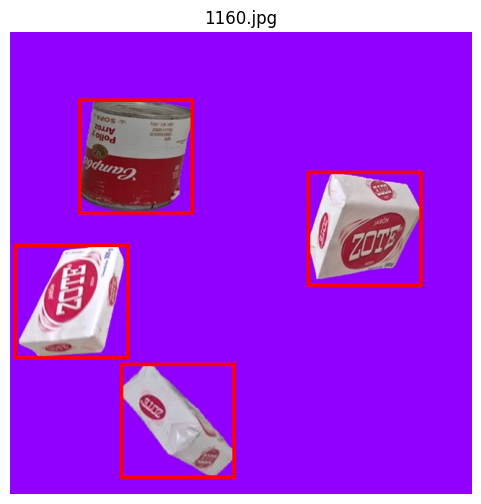

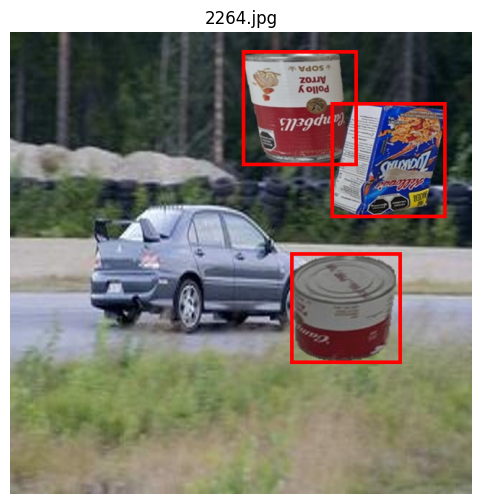

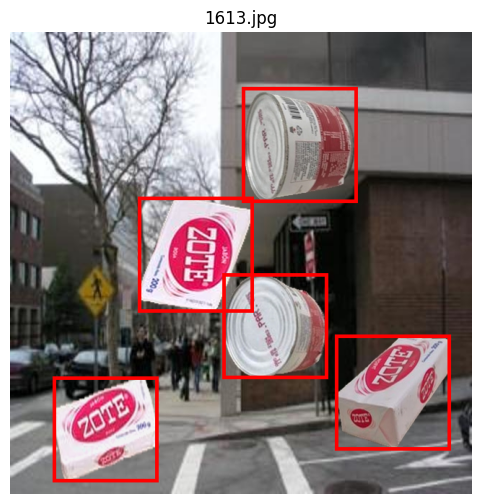

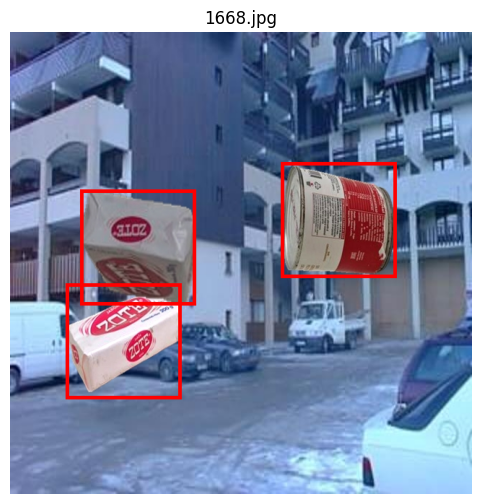

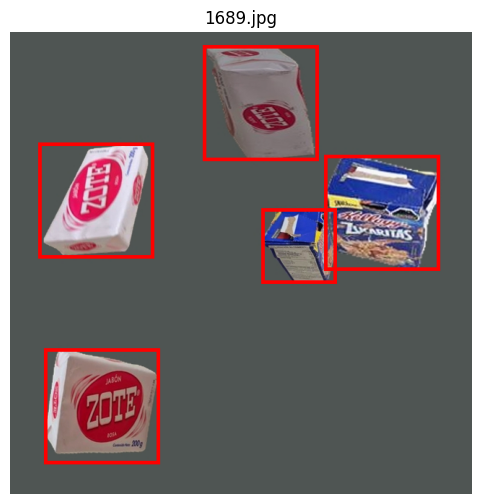

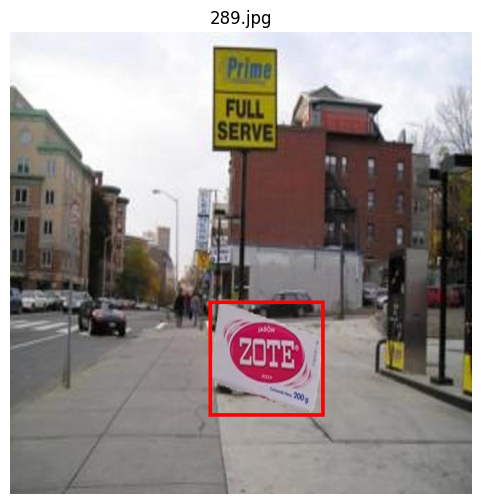

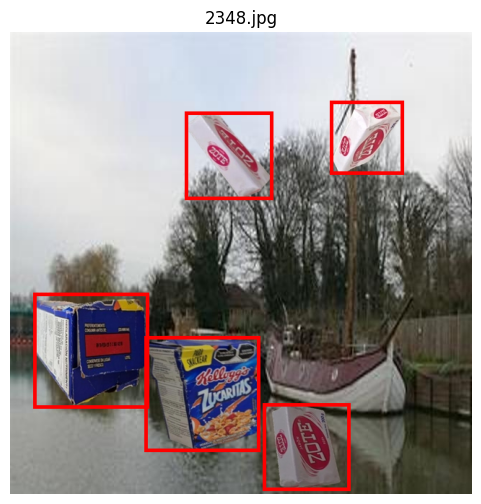

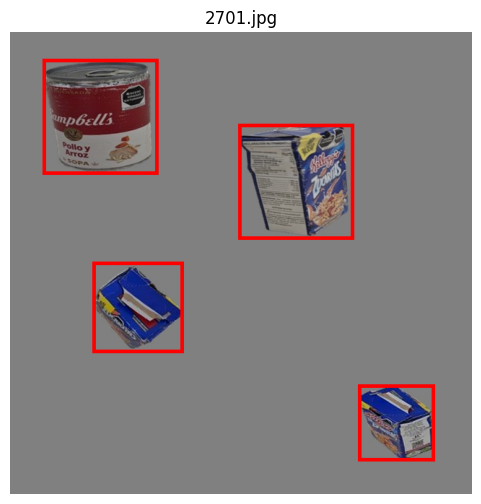

In [39]:
# === CONFIG ===
images_dir = workdir + "ds_final/train/images"
labels_dir = workdir + "ds_final/train/labels"
num_samples = 15

# Get all image files
image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png'))]
sampled_files = random.sample(image_files, min(num_samples, len(image_files)))

for image_file in sampled_files:
    image_path = os.path.join(images_dir, image_file)
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(labels_dir, label_file)

    # Load image
    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)
    img_width, img_height = image.size

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            labels = f.readlines()

        for label in labels:
            cls, x_center, y_center, w, h = map(float, label.strip().split())
            x_center *= img_width
            y_center *= img_height
            w *= img_width
            h *= img_height
            x0 = x_center - w / 2
            y0 = y_center - h / 2
            x1 = x_center + w / 2
            y1 = y_center + h / 2
            draw.rectangle([x0, y0, x1, y1], outline="red", width=5)
            draw.text((x0, y0), str(int(cls)), fill="red")

    # Show image with bounding boxes
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(image_file)
    plt.axis("off")
    plt.show()

## Split images

Take a percentage of the images and move them to test and validation directories.

In [40]:
import os
import shutil
import random

validation = 0.1
test = 0.1

# Assumes test has 100% of data
output_folder = workdir + "/ds_final/"
trainfolder = output_folder + "train/"
trainfolderimgs = trainfolder + "images/"
trainfolderlabels = trainfolder + "labels/"
testfolder = output_folder + "test/"
testfolderimgs = testfolder + "images/"
testfolderlabels = testfolder + "labels/"
validfolder = output_folder + "valid/"
validfolderimgs = validfolder + "images/"
validfolderlabels = validfolder + "labels/"

fullSize = len(os.listdir(trainfolderimgs))
validSize = int(fullSize * validation)
testSize = int(fullSize * test)

for i in range(validSize):
    filelist = os.listdir(trainfolderimgs)
    #randomize file list, to not pick files in order
    random.shuffle(filelist)
    filetomove = filelist[i]
    #take out .jpg, .png, etc
    filetomovename = filetomove[:-4]
    #move images
    shutil.move(f"{trainfolderimgs}{filetomove}", f"{validfolderimgs}{filetomove}")
    #move labels
    shutil.move(f"{trainfolderlabels}{filetomovename}.txt", f"{validfolderlabels}{filetomovename}.txt")
for i in range(testSize):
    filetomove = os.listdir(trainfolderimgs)[i]
    #take out .jpg, .png, etc
    filetomovename = filetomove[:-4]
    #move images
    shutil.move(f"{trainfolderimgs}{filetomove}", f"{testfolderimgs}{filetomove}")
    #move labels
    shutil.move(f"{trainfolderlabels}{filetomovename}.txt", f"{testfolderlabels}{filetomovename}.txt")

#Validation
print(f"Train size is now: {len(os.listdir(trainfolderimgs))}")
print(f"Validation size is now: {len(os.listdir(validfolderimgs))}")
print(f"Test size is now: {len(os.listdir(testfolderimgs))}")

Train size is now: 2400
Validation size is now: 300
Test size is now: 300


## Train a yolo model with the dataset

Clean invalid labels and then train yolo.

In [41]:
!pip install ultralytics
from ultralytics import YOLO

import os
os.chdir(workdir)

# Load a YOLOv8 model (you can also use 'yolov8n.yaml', 'yolov8s.yaml', etc.)
model = YOLO("yolo11m.yaml")

# Train the model
model.train(
    data=workdir + "ds_final/data.yaml",
    epochs=200,
    imgsz=640,
    batch=16,
    perspective=0.0005,
    scale=0.4,
    translate=0.05,
    degrees=5,
    shear=1,
    hsv_s=0.5,
    hsv_v=0.3,
    flipud=0.2,
    patience=30,
    save_period=25,
)

Looking in indexes: http://jetson.webredirect.org/jp6/cu126, https://pypi.ngc.nvidia.com
New https://pypi.org/project/ultralytics/8.3.118 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.113 🚀 Python-3.10.12 torch-2.4.0 CUDA:0 (Orin, 62841MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.yaml, data=/content/ds_final/data.yaml, epochs=200, time=None, patience=30, batch=16, imgsz=640, save=True, save_period=25, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, class

train: Scanning /content/ds_final/train/labels... 2400 images, 234 backgrounds, 0 corrupt: 100%|██████████| 2400/2400 [00:03<00:00, 660.18it/s]


train: New cache created: /content/ds_final/train/labels.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 894.4±387.9 MB/s, size: 176.1 KB)


val: Scanning /content/ds_final/valid/labels... 300 images, 36 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<00:00, 1342.00it/s]

val: New cache created: /content/ds_final/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      7.84G       2.67      3.331      3.642         67        640: 100%|██████████| 150/150 [02:01<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]

                   all        300        796      0.355      0.301      0.331      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200       9.4G      1.931      1.764      2.423         75        640: 100%|██████████| 150/150 [01:52<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.47it/s]

                   all        300        796      0.636      0.578      0.595      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200       9.4G      1.501      1.259      1.945         69        640: 100%|██████████| 150/150 [01:50<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.47it/s]

                   all        300        796      0.848      0.898       0.95       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200       9.4G      1.283     0.9804      1.724         70        640: 100%|██████████| 150/150 [01:49<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]

                   all        300        796      0.937      0.936      0.961      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200       9.4G      1.181     0.8375      1.619         64        640: 100%|██████████| 150/150 [01:49<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.46it/s]

                   all        300        796      0.952      0.963      0.994       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200       9.4G      1.092     0.7495      1.543         71        640: 100%|██████████| 150/150 [01:49<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.47it/s]

                   all        300        796      0.982      0.959      0.992      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200       9.4G      1.075     0.7048      1.515         80        640: 100%|██████████| 150/150 [01:49<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]

                   all        300        796      0.988      0.985      0.994      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200       9.4G     0.9921     0.6357      1.447         70        640: 100%|██████████| 150/150 [01:49<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.46it/s]

                   all        300        796      0.907       0.92      0.972      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200       9.4G     0.9777     0.6164      1.441         69        640: 100%|██████████| 150/150 [01:49<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]

                   all        300        796      0.991      0.998      0.995      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200       9.4G     0.9563     0.5955      1.419         73        640: 100%|██████████| 150/150 [01:49<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.47it/s]

                   all        300        796      0.991      0.985      0.993      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200       9.4G     0.9305     0.5706      1.397         83        640: 100%|██████████| 150/150 [01:49<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]

                   all        300        796      0.928      0.952      0.992      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200       9.4G     0.9171     0.5507      1.382         77        640: 100%|██████████| 150/150 [01:49<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]

                   all        300        796      0.992      0.971      0.994      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200       9.4G     0.9005     0.5495      1.363         64        640: 100%|██████████| 150/150 [01:49<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.47it/s]

                   all        300        796      0.946      0.935      0.971      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200       9.4G     0.8798     0.5152      1.349         64        640: 100%|██████████| 150/150 [01:49<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

                   all        300        796      0.993      0.998      0.995      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200       9.4G     0.8818     0.5141      1.349         76        640: 100%|██████████| 150/150 [01:49<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]

                   all        300        796      0.999          1      0.995      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200       9.4G     0.8824      0.521      1.345         72        640: 100%|██████████| 150/150 [01:49<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

                   all        300        796      0.997      0.996      0.994      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200       9.4G      0.813     0.4529      1.282         80        640: 100%|██████████| 150/150 [01:49<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]

                   all        300        796      0.999          1      0.995      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200       9.4G     0.8148     0.4444      1.283         78        640: 100%|██████████| 150/150 [01:49<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

                   all        300        796      0.996      0.998      0.995      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200       9.4G     0.8096     0.4397      1.284         77        640: 100%|██████████| 150/150 [01:49<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]

                   all        300        796      0.999      0.999      0.995      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200       9.4G     0.8047     0.4407      1.279         78        640: 100%|██████████| 150/150 [01:49<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

                   all        300        796      0.998          1      0.995      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200       9.4G     0.8013     0.4328      1.276         41        640: 100%|██████████| 150/150 [01:49<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]

                   all        300        796      0.983       0.98      0.994      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200       9.4G     0.7949     0.4304      1.271         92        640: 100%|██████████| 150/150 [01:49<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.47it/s]

                   all        300        796      0.993      0.997      0.994      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200       9.4G     0.7913     0.4301      1.272         73        640: 100%|██████████| 150/150 [01:49<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

                   all        300        796      0.998      0.998      0.995      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200       9.4G     0.7897     0.4181      1.262         79        640: 100%|██████████| 150/150 [01:49<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

                   all        300        796          1          1      0.995       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200       9.4G     0.7911     0.4222      1.266         66        640: 100%|██████████| 150/150 [01:49<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

                   all        300        796      0.999          1      0.995      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200       9.4G     0.7853     0.4203      1.257         67        640: 100%|██████████| 150/150 [01:49<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

                   all        300        796      0.999          1      0.995       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200       9.4G     0.7844     0.4217      1.251         87        640:  34%|███▍      | 51/150 [00:37<01:14,  1.33it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

     73/200       9.4G     0.6428     0.3395      1.148         78        640: 100%|██████████| 150/150 [01:49<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

                   all        300        796          1          1      0.995      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200       9.4G     0.6384     0.3376      1.141         89        640: 100%|██████████| 150/150 [01:49<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

                   all        300        796          1          1      0.995      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200       9.4G     0.6397     0.3384      1.144         74        640: 100%|██████████| 150/150 [01:49<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

                   all        300        796          1          1      0.995      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200       9.4G     0.6364     0.3398      1.143         53        640: 100%|██████████| 150/150 [01:49<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

                   all        300        796          1          1      0.995      0.934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200       9.4G     0.6295     0.3346      1.136         59        640: 100%|██████████| 150/150 [01:49<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

                   all        300        796          1          1      0.995      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200       9.4G     0.6274     0.3366      1.136         67        640: 100%|██████████| 150/150 [01:49<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

                   all        300        796          1          1      0.995      0.934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200       9.4G      0.618     0.3301      1.127         58        640: 100%|██████████| 150/150 [01:49<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]

                   all        300        796          1          1      0.995      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200       9.4G     0.6129      0.326      1.129         74        640: 100%|██████████| 150/150 [01:50<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]

                   all        300        796          1          1      0.995      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200       9.4G     0.6141      0.326      1.128         66        640: 100%|██████████| 150/150 [01:50<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

                   all        300        796          1          1      0.995      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200       9.4G     0.6178     0.3288      1.134         54        640: 100%|██████████| 150/150 [01:50<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]

                   all        300        796          1          1      0.995      0.936



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200       9.4G      0.624     0.3319      1.139         64        640: 100%|██████████| 150/150 [01:49<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]

                   all        300        796          1          1      0.995      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200       9.4G     0.6179     0.3278      1.131         63        640: 100%|██████████| 150/150 [01:50<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

                   all        300        796          1          1      0.995      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200       9.4G     0.5948     0.3164      1.108         70        640: 100%|██████████| 150/150 [01:49<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

                   all        300        796          1          1      0.995      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200       9.4G     0.6064     0.3195      1.118         96        640: 100%|██████████| 150/150 [01:49<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

                   all        300        796          1          1      0.995      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200       9.4G     0.5939      0.316      1.108         90        640: 100%|██████████| 150/150 [01:49<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]

                   all        300        796          1          1      0.995      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200       9.4G     0.5984     0.3199      1.116         67        640: 100%|██████████| 150/150 [01:49<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

                   all        300        796          1          1      0.995      0.936



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200       9.4G     0.5926     0.3077      1.116         76        640: 100%|██████████| 150/150 [01:50<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]

                   all        300        796          1          1      0.995      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200       9.4G     0.5861     0.3141      1.107         77        640: 100%|██████████| 150/150 [01:49<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

                   all        300        796          1          1      0.995      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200       9.4G     0.5838     0.3109      1.104         78        640: 100%|██████████| 150/150 [01:50<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

                   all        300        796          1          1      0.995       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200       9.4G     0.5889     0.3144      1.106         55        640: 100%|██████████| 150/150 [01:49<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

                   all        300        796          1          1      0.995      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200       9.4G     0.5895     0.3105      1.107         87        640: 100%|██████████| 150/150 [01:49<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

                   all        300        796          1          1      0.995      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200       9.4G     0.5742     0.3056      1.101         67        640:  97%|█████████▋| 145/150 [01:46<00:03,  1.38it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [45]:
# Test the model
import os
os.chdir(workdir)

from ultralytics import YOLO
# Load the best trained model
model = YOLO(workdir + "runs/detect/train/weights/epoch125.pt")

# Run inference on test images
results = model.predict(source=workdir + "test", save=True, conf=0.5)


image 1/14 /content/test/20250423_120416.jpg: 640x320 1 Can, 1 Box, 45.6ms
image 2/14 /content/test/20250423_120418.jpg: 640x320 2 Cans, 3 Boxs, 43.9ms
image 3/14 /content/test/20250423_120420.jpg: 640x320 1 Can, 3 Boxs, 40.9ms
image 4/14 /content/test/20250423_120422.jpg: 640x320 1 Box, 44.1ms
image 5/14 /content/test/20250423_120429.jpg: 640x320 1 Can, 1 Box, 44.0ms
image 6/14 /content/test/20250423_120431.jpg: 640x320 1 Can, 42.7ms
image 7/14 /content/test/20250423_120432.jpg: 640x320 1 Can, 44.5ms
image 8/14 /content/test/20250423_120436.jpg: 640x320 1 Soap, 1 Can, 44.3ms
image 9/14 /content/test/20250423_120437.jpg: 640x320 1 Soap, 1 Can, 44.3ms
image 10/14 /content/test/20250423_120439.jpg: 640x320 1 Can, 43.3ms
image 11/14 /content/test/20250423_120441.jpg: 640x320 1 Soap, 1 Can, 44.6ms
image 12/14 /content/test/20250423_120443.jpg: 640x320 1 Soap, 42.9ms
image 13/14 /content/test/20250423_120447.jpg: 640x320 1 Soap, 41.1ms
image 14/14 /content/test/20250423_120450.jpg: 640x320

## TODO:
100 fotos por clase
3000 fotos generadas
agregar bg de colores y fotos del lab